In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
from vis_settings import lag_colors as colors

In [3]:
fair_temperatures_low = xr.open_dataset("../data/outputs/temperature_low_emissions.nc").to_array().isel(variable=0)
fair_temperatures_med = xr.open_dataset("../data/outputs/temperature_medium_emissions.nc").to_array().isel(variable=0)
fair_temperatures_high = xr.open_dataset("../data/outputs/temperature_high_emissions.nc").to_array().isel(variable=0)
fair_temperatures=fair_temperatures_low

In [4]:
ds_timebounds = pd.read_csv("../data/outputs/timebounds.csv")
timebounds=ds_timebounds['0'].values

# Make figures

In [5]:
baseline_scenario = 'low'

scenarios = [
    "baseline",
  "instant-removal-offsetting",
 "physical-delay-offsetting",
 "accelerated-emissions-offsetting",
    "upfront-embodied-offsetting",
]

fancy_titles = {
    'baseline': 'Baseline',
    "instant-removal-offsetting":"Instant Removal",
    "physical-delay-offsetting":"Physical / Counterfactual Delay",
    "accelerated-emissions-offsetting":"Accelerated Emissions",
    "upfront-embodied-offsetting":"Upfront Emissions",
}

linestyles = {
    'baseline': '-',
    "instant-removal-offsetting":"--",
    "physical-delay-offsetting":"-",
    "accelerated-emissions-offsetting":"-",
    "upfront-embodied-offsetting":"-",
}

In [6]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

### Difference from baseline

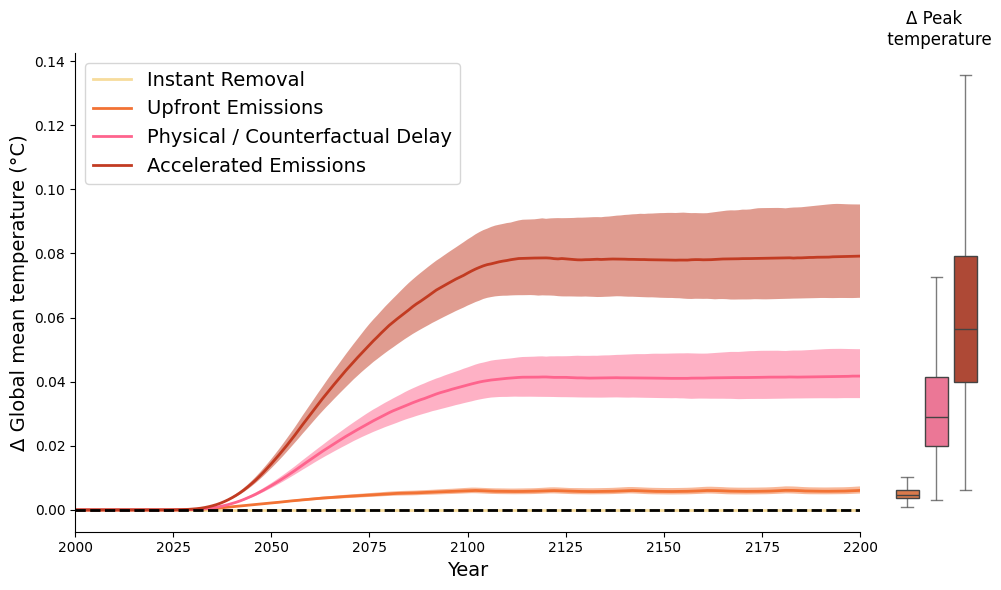

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True,
                        gridspec_kw={'width_ratios': [9, 1]})

scenarios_to_plot = ['instant-removal-offsetting',
                     'upfront-embodied-offsetting',
 'physical-delay-offsetting',
 'accelerated-emissions-offsetting',
 ]

pp = (25,75)

ax=axes[0]

for i, scenario in enumerate(scenarios_to_plot):
    ax.fill_between(
        timebounds,
        np.percentile(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - fair_temperatures.loc[dict(scenario="baseline", layer=0)],
            pp[0],
            axis=1,
        ),
        np.percentile(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - fair_temperatures.loc[dict(scenario="baseline", layer=0)],
            pp[1],
            axis=1,
        ),
        color=colors[scenario],
        alpha=0.5,
        lw=0
    )

    ax.plot(
        timebounds,
        np.median(
            fair_temperatures.loc[dict(scenario=scenario, layer=0)]
            - fair_temperatures.loc[dict(scenario="baseline", layer=0)],
            axis=1,
        ),
        color=colors[scenarios_to_plot[i]],label=fancy_titles[scenarios_to_plot[i]],
        lw=2
    )
ax.set_xlim(2000, 2200)
ax.legend(loc='upper left', fontsize=14)
ax.axhline(y=0, color="k", ls="--", lw=2, label='Baseline')
ax.set_ylabel('Δ Global mean temperature (°C)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


#### Peak temperatures
ax=axes[1]
colors_to_plot = [colors[scenario] for scenario in scenarios_to_plot[1:]]

peak_temperatures = (fair_temperatures[:451].sel(layer=0).rolling(timebounds=20).mean().max(dim='timebounds')
                     - (np.average(
                fair_temperatures.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ]))).transpose().to_pandas()


for i,scenario in enumerate(scenarios_to_plot[1:]):
    peak_temp_diff = (peak_temperatures[scenario]-
                      peak_temperatures["baseline"])
    if i==0:
        peak_temp_diffs=peak_temp_diff.to_frame(name=fancy_titles[scenario])
    else:
        peak_temp_diffs[fancy_titles[scenario]]=peak_temp_diff

sns.boxplot(
    data=peak_temp_diffs,
    palette=colors_to_plot,
    ax=ax,
    boxprops=dict(alpha=1), 
    whiskerprops=dict(alpha=0.7),
    capprops=dict(alpha=0.7),
    medianprops=dict(alpha=1),
    showfliers=False
)
ax.set_xticklabels([])
ax.set_xticks([])
ax.tick_params(left=False, labelleft=False)
ax.set_title('Δ Peak \n temperature')
ax.set_xlim(-0.5, 2.5)
for spine in ax.spines.values():
    spine.set_visible(False)
fig.tight_layout()
plt.savefig('../figures/Figure4.pdf')
plt.savefig('../figures/Figure4.png', dpi=200)